In [4]:
import pandas as pd
from keras.models import load_model
import numpy as np
from skimage import transform, io, img_as_float, exposure, morphology, img_as_ubyte,filters
import matplotlib.pyplot as plt
import os
from PIL import Image
from shutil import move,copy
import cv2
import torch
import pydicom

In [5]:
BASE_PATH = os.path.dirname(os.path.realpath(__name__))
BASE_PATH = '/Users/alvaromoure/Desarrollo/UPM/TFM/Alvaro-TFM'

In [6]:
# Load model

# model_name = '/home/julian/Documents/PythonExperiments/COVIDNet/segmenter/trained_model.hdf5'
model_name = os.path.join(BASE_PATH,'segmenter','trained_model.hdf5')
UNet = load_model(model_name)

2022-05-18 16:58:42.673730: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def loadDataGeneral(path, im_shape):
    """Function for loading arbitrary data in standard formats"""
    X = []   
    image = Image.open(path).convert('RGB')
    #image = cv2.imread(path,cv2.IMREAD_ANYDEPTH)
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    image = np.array(image)
    img = img_as_float(image)
    img = transform.resize(img, im_shape)
    img = exposure.equalize_hist(img)
    img = np.expand_dims(img, -1)
    X.append(img)
    X = np.array(X)
    X -= X.mean()
    X /= X.std()
    return (X,img)

In [7]:
def remove_small_regions(img, size):
    """Morphologically removes small (less than size) connected regions of 0s or 1s."""
    img = morphology.remove_small_objects(img, size)
    img = morphology.remove_small_holes(img, size)
    return img

In [ ]:
im_shape = (256, 256)
#path = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/OrgImages/'
#path = os.path.join(BASE_PATH,'data','OrgImages\\')
path = '/Volumes/Alvaro HD/UPM/Corpus TFM/COVID/hackathon/test/'
#path2 = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/RemoveSegmented/'
path2 = os.path.join(BASE_PATH,'data','RemoveSegmented')
#path3 = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/BrokenFiles/'
path3 = os.path.join(BASE_PATH,'data','BrokenFiles')

path4 = os.path.join(BASE_PATH,'data','OrgImagesSegmented')

if not os.path.exists(path): 
  os.makedirs(path)

if not os.path.exists(path2): 
  os.makedirs(path2)

if not os.path.exists(path3): 
  os.makedirs(path3)

if not os.path.exists(path4): 
  os.makedirs(path4)

arr = os.listdir(path + '.')
arr.sort()
for j,file in enumerate(arr):
    try:
        image_name = path + file
        X,img_org = loadDataGeneral(image_name, im_shape)
        img = exposure.rescale_intensity(np.squeeze(X), out_range=(0,1))
        img = np.sum(img,axis=2)[None,:,:,None]
        pred = UNet.predict(img)
        #-------------------------
        pr = pred > 0.5
        # Remove regions smaller than 2% of the image
        pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))
        pr2 = np.squeeze(pr)
        seg_img = np.squeeze(img_org)*pr2[:,:,None]#np.dstack((pr2, pr2, pr2))
        maximo = np.max(seg_img)
        minimo = np.min(seg_img)
        if (maximo==0) and (minimo == 0):
            #print(file)
            save_path = os.path.join(path2,file)
            io.imsave(save_path,img_as_ubyte(seg_img))
        else:
            seg_img /= maximo
            #seg_img = (seg_img - minimo)/(maximo-minimo)
            #io.imshow(seg_img)
            save_path = os.path.join(path4,file)
            io.imsave(save_path,img_as_ubyte(seg_img))
    except Exception as e:
      print(e)
      move(image_name,os.path.join(path3,file))
      #break

# Segmentation for Hackathon images

Due to the fact that some images are inverted (color) the vanilla segmenter does not perform well in those images. Lets try modififying the code a little bit to detect this color inversion.

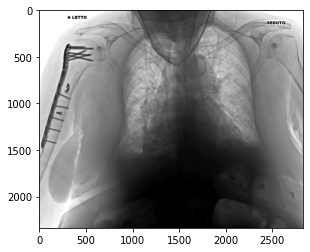

In [10]:
image = load_image(image_name)
plt.imshow(img,'gray')

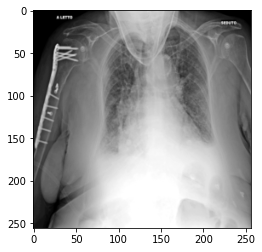

In [11]:
img = load_image(image_name)
img = preprocess(img)
img = transform.resize(img, im_shape)
plt.imshow(img,'gray')

In [3]:
def load_image(filename):
    image = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    image = np.clip(image, np.quantile(image, 0.02), np.quantile(image, 0.98))
    return image

def is_inverted(image, corner_ratio=0.2, center_ratio=0.05, bottom=False):
    height, width = image.shape[:2]
    corner_size = (int(height*corner_ratio), int(width*corner_ratio))
    tl = image[:corner_size[0], :corner_size[1]].flatten()
    bl = image[-corner_size[0]:, :corner_size[1]].flatten()
    tr = image[:corner_size[0], -corner_size[1]:].flatten()
    br = image[-corner_size[0]:, -corner_size[1]:].flatten()
    if bottom:
        corners = np.hstack([tl, bl, tr, br])
    else:
        corners = np.hstack([tl, tr])

    center = image[
        int(height*(0.5-center_ratio)):int(height*(0.5+center_ratio)),
        int(width*(0.5-center_ratio)):int(width*(0.5+center_ratio))
    ]
    return center.mean() < corners.mean()


def preprocess(image):
    if is_inverted(image):
        return image.max() - image
    image = exposure.equalize_adapthist(image, kernel_size=8, clip_limit=0.01)
    #image = filter.median(image)
    return image

In [7]:
image.shape

NameError: name 'image' is not defined

In [86]:
img = load_image(image_name)

image = preprocess(img)
plt.imshow(image,'gray')
plt.show()

ValueError: too many values to unpack (expected 2)

In [9]:
# Hackathon version


im_shape = (256, 256)
#path = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/OrgImages/'
#path = os.path.join(BASE_PATH,'data','OrgImages\\')
path = '/Volumes/Alvaro HD/UPM/Corpus TFM/COVID/hackathon/test/'
#path2 = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/RemoveSegmented/'
path2 = os.path.join(BASE_PATH,'data','RemoveSegmented')
#path3 = '/home/julian/Documents/PythonExperiments/COVIDNet/Datos/DatosExperimentos_3/BrokenFiles/'
path3 = os.path.join(BASE_PATH,'data','BrokenFiles')

path4 = os.path.join(BASE_PATH,'data','OrgImagesSegmented')

if not os.path.exists(path):
  os.makedirs(path)

if not os.path.exists(path2):
  os.makedirs(path2)

if not os.path.exists(path3):
  os.makedirs(path3)

if not os.path.exists(path4):
  os.makedirs(path4)

arr = os.listdir(path + '.')
arr.sort()
for j,file in enumerate(arr):
    try:
        image_name = path + file
        img = load_image(image_name)
        img = exposure.rescale_intensity(img, out_range=(0,1))
        img = exposure.equalize_adapthist(img)
        original_shape = img.shape[:2]
        #img = preprocess(img)

        img_re = transform.resize(img, im_shape)
        #img_re = img_re[None,:,:,None]
        img_re = np.sum(img_re,axis=2)[None,:,:,None]
        pred = UNet.predict(img_re)
        #-------------------------
        pr = pred > 0.5
        # Remove regions smaller than 2% of the image
        pr = remove_small_regions(pr, 0.02 * np.prod(im_shape))
        pr = transform.resize(np.squeeze(pr),original_shape)
        #seg_img = img * np.squeeze(pr[:,:])#np.dstack((pr2, pr2, pr2))
        seg_img = img * np.dstack((pr, pr, pr))
        maximo = np.max(seg_img)
        minimo = np.min(seg_img)
        if (maximo==0) and (minimo == 0):
            save_path = os.path.join(path2,file)
            io.imsave(save_path,img_as_ubyte(seg_img))
        else:
            #seg_img /= maximo
            #seg_img = (seg_img - minimo)/(maximo-minimo)
            #io.imshow(seg_img)
            save_path = os.path.join(path4,file)
            io.imsave(save_path,img_as_ubyte(seg_img))
    except Exception as e:
      raise(e)
      move(image_name,os.path.join(path3,file))
      #break

KeyboardInterrupt: 

In [101]:
img_raw.shape

(2336, 2836)

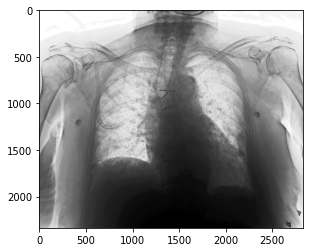

In [60]:
plt.imshow(img,'gray')
plt.show()

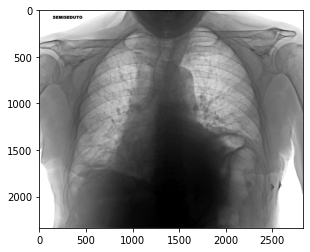

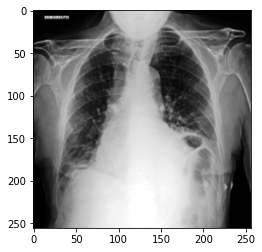

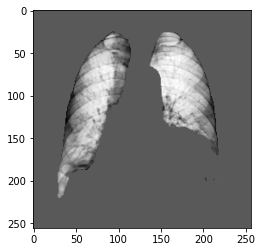

In [136]:
img_raw = load_image(image_name)
plt.imshow(img_raw,'gray')
plt.show()

X = []


img_2 = exposure.rescale_intensity(img_raw, out_range=(0,1))
img_2 = img_2.max() - img_2
img_2 = exposure.equalize_hist(img_2)
#img_2 = cv2.normalize(img_2,None,alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
X.append(img_2)
X = np.array(X)
X -= X.mean()
X /= X.std()
img_2 = X[0]
#img_2 = transform.resize(img_2,(256,256,3))
#img_2 = np.sum(img_2,axis=2)[None,:,:,None]
img_2 = transform.resize(img_2,(256,256))
img_2 = img_2[None,:,:,None]


plt.imshow(np.squeeze(img_2),'gray')
plt.show()
pr = UNet.predict(img_2)
pr = pr > 0.5
img_out = np.squeeze(pr)*np.squeeze(img_2)
img_out = img_out.max()-img_out
plt.imshow(img_out,'gray')
plt.show()

In [109]:
img_raw.shape

(2336, 2836, 3)

In [106]:
img = load_image(image_name)
if is_inverted(img):
    img = preprocess(img)
img = transform.resize(img, im_shape)
img = np.resize(img,(1,256,256,1))
img.shape

(1, 256, 256, 1)

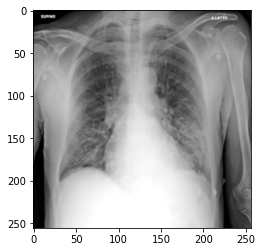

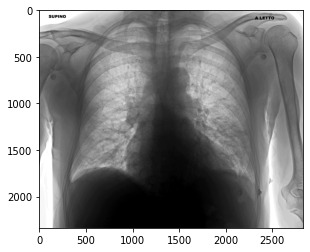